In [1]:
import os
import sys
import json
import random
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
color_map = {
    0: {'name': 'unlabeled', 'color': [0, 0, 0]},
    1: {'name': 'road', 'color': [128, 64, 128]},
    2: {'name': 'sidewalk', 'color': [244, 35, 232]},
    3: {'name': 'building', 'color': [70, 70, 70]},
    4: {'name': 'wall', 'color': [102, 102, 156]},
    5: {'name': 'fence', 'color': [190, 153, 153]},
    6: {'name': 'pole', 'color': [153, 153, 153]},
    7: {'name': 'traffic light', 'color': [250, 170, 30]},
    8: {'name': 'traffic sign', 'color': [220, 220, 0]},
    9: {'name': 'vegetation', 'color': [107, 142, 35]},
    10: {'name': 'terrain', 'color': [152, 251, 152]},
    11: {'name': 'sky', 'color': [70, 130, 180]},
    12: {'name': 'pedestrian', 'color': [220, 20, 60]},
    13: {'name': 'rider', 'color': [255, 0, 0]},
    14: {'name': 'Car', 'color': [0, 0, 142]},
    15: {'name': 'truck', 'color': [0, 0, 70]},
    16: {'name': 'bus', 'color': [0, 60, 100]},
    17: {'name': 'train', 'color': [0, 80, 100]},
    18: {'name': 'motorcycle', 'color': [0, 0, 230]},
    19: {'name': 'bicycle', 'color': [119, 11, 32]},
    20: {'name': 'static', 'color': [110, 190, 160]},
    21: {'name': 'dynamic', 'color': [170, 120, 50]},
    22: {'name': 'other', 'color': [55, 90, 80]},
    23: {'name': 'water', 'color': [45, 60, 150]},
    24: {'name': 'road line', 'color': [157, 234, 50]},
    25: {'name': 'ground', 'color': [81, 0, 81]},
    26: {'name': 'bridge', 'color': [150, 100, 100]},
    27: {'name': 'rail track', 'color': [230, 150, 140]},
    28: {'name': 'guard rail', 'color': [180, 165, 180]}
}

def seg_label2color(label):

    color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for i in color_map.keys():
        color[label[..., 0] == i] = np.array(color_map[i]['color'])
    
    return color

def fov_transform(img, target_fov=90, src_fov=150):
    h, w = img.shape[:2]
    f = w / 2 / np.tan(np.radians(src_fov / 2))
    src_intrinsics = np.array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]], dtype=np.float32)
    
    new_w = int(2 * f * np.tan(np.radians(target_fov / 2)))
    new_h = int(h * new_w / w)
    dst_intrinsics = np.array([[f, 0, new_w / 2], [0, f, new_h / 2], [0, 0, 1]], dtype=np.float32)

    x = np.arange(new_w)
    y = np.arange(new_h)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
    xyz = xyz @ np.linalg.inv(dst_intrinsics).T
    xyz = xyz @ src_intrinsics.T

    dst_img = cv2.remap(img, xyz[..., 0].astype(np.float32), xyz[..., 1].astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

    return dst_img  

In [3]:
data_path = "../data/carla"
data_folders = []
for file in sorted(os.listdir(data_path)):
    if file.endswith(".json"):
        continue
    data_folders.append(file)
    print(file)

data_collect_town01_results
data_collect_town02_results
data_collect_town03_results
data_collect_town04_results
data_collect_town05_results


In [4]:
# scene = random.choice(data_folders)
# route = random.choice(os.listdir(os.path.join(data_path, scene)))
scene = data_folders[0]
route = sorted(os.listdir(os.path.join(data_path, scene)))[0]
scene_path = os.path.join(data_path, scene, route)
print(f"Selected scene: {scene}, route: {route}")

info = json.load(open(os.path.join(data_path, scene + ".json")))

num_frames = len(os.listdir(os.path.join(scene_path, "lidar")))
frame_idx = random.randint(0, num_frames - 1)
print(f"Selected frame: {frame_idx} / {num_frames}")

Selected scene: data_collect_town01_results, route: routes_town01_01_08_10_07_24
Selected frame: 152 / 189


In [5]:
rgb_front = cv2.imread(os.path.join(scene_path, "rgb_front", f"{frame_idx:04d}.png"))
seg_front = cv2.imread(os.path.join(scene_path, "seg_front", f"{frame_idx:04d}.png"))
depth_front = cv2.imread(os.path.join(scene_path, "depth_front", f"{frame_idx:04d}.png"))
normalized_depth = (depth_front[:, :, 2] + depth_front[:, :, 1] * 256.0 + depth_front[:, :, 0] * 256.0 * 256.0) / (256.0 * 256.0 * 256.0 - 1)
normalized_depth = normalized_depth * 1000.0  # in meters

bev = cv2.imread(os.path.join(scene_path, "bev", f"{frame_idx:04d}.png"))
lidar = np.load(os.path.join(scene_path, "lidar", f"{frame_idx:04d}.npy"))
supervision = np.load(os.path.join(scene_path, "supervision", f"{frame_idx:04d}.npy"), allow_pickle=True)

(-0.5, 427.5, 239.5, -0.5)

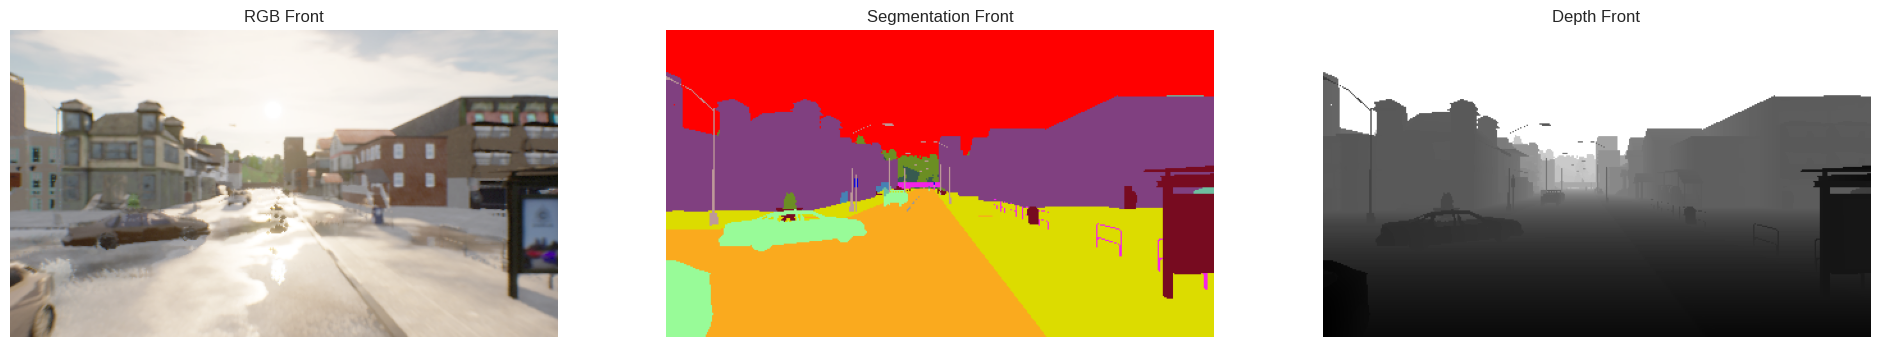

In [6]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(fov_transform(rgb_front), cv2.COLOR_BGR2RGB))
plt.title("RGB Front")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(fov_transform(seg_label2color(seg_front)))
plt.title("Segmentation Front")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(fov_transform(np.log(normalized_depth)), cmap="gray")
plt.title("Depth Front")
plt.axis("off")

(-25.0, 25.0)

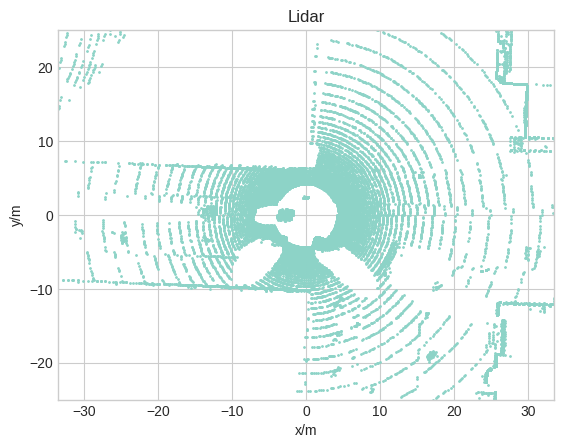

In [7]:
# require instance and optical flow
# 外参问题
plt.figure()
plt.scatter(lidar[:, 0], lidar[:, 1], s=1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.title("Lidar")
plt.axis("equal")
plt.xlim(-25, 25)
plt.ylim(-25, 25)

In [8]:
if not os.path.exists(os.path.join(scene_path, 'input')):
    os.makedirs(os.path.join(scene_path, 'input'))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
H, W = fov_transform(cv2.imread(os.path.join(scene_path, "rgb_front", "0000.png"))).shape[:2]
# video = cv2.VideoWriter(os.path.join(scene_path, 'video.mp4'), fourcc, 30, (W, H))
for idx in tqdm(range(num_frames)):
    rgb_image = fov_transform(cv2.imread(os.path.join(scene_path, "rgb_front", f"{idx:04d}.png")))
    cv2.imwrite(os.path.join(scene_path, 'input', f"{idx:04d}.png"), rgb_image)
    # video.write(rgb_image)
# video.release()
# print(f"Video saved to {os.path.join(scene_path, 'video.mp4')}")

  2%|▏         | 3/189 [00:00<00:09, 20.40it/s]

100%|██████████| 189/189 [00:09<00:00, 20.77it/s]
